<a href="https://colab.research.google.com/github/DajanaIsaku/PPPO_DetekcijaObjekata/blob/main/DetekcijaObjekata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Projektni zadatak iz predmeta principi prezentacije i prepoznavanja oblika**

Student: Dajana Isaku IT 27/2020

Tema projektnog zadatka: Detekcija objekata (broda)


In [36]:
from google.colab import drive


In [37]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
!pip install gdown


In [39]:
import gdown


In [40]:
import os
import sys
import random
import math
import warnings
import numpy as np
import cv2



In [41]:
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd
import glob
import numpy as np
import pandas as pd
from skimage.io import imread

In [42]:
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable()

In [43]:

!git clone https://github.com/maxw1489/Mask_RCNN.git
os.chdir('Mask_RCNN')

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 31 (delta 6), reused 20 (delta 0), pack-reused 0
Receiving objects: 100% (31/31), 10.81 MiB | 29.28 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [44]:
sys.path.append(os.path.join('Mask_RCNN'))

In [45]:
from mrcnn.config import Config


In [46]:
from mrcnn import utils


In [47]:
import mrcnn.model as modellib


In [48]:
from mrcnn import visualize


In [49]:
from mrcnn.model import log


In [50]:

!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Dec  6  2021 mask_rcnn_coco.h5


In [51]:

data_dir = '/content/drive/MyDrive/Ships_Detection'
main_dir = '/content/drive/MyDrive/'


In [52]:
train_dir = os.path.join(data_dir, 'train_v2')
test_dir = os.path.join(data_dir, 'test_v2')

In [53]:

import os

train_images = os.listdir(train_dir)
num_train_images = len(train_images)

test_images = os.listdir(test_dir)
num_test_images = len(test_images)



In [54]:
# slike za obuku
print(num_train_images)

# slike za testiranje
print(num_test_images)

33483
6882


In [55]:

import pandas as pd
import os

In [56]:
csv_file1 = os.path.join('/content/drive/MyDrive/Ships_Detection/', 'sample_submission_v2.csv')
csv_file2 = os.path.join('/content/drive/MyDrive/Ships_Detection/', 'train_ship_segmentations_v2.csv')


In [57]:
df1 = pd.read_csv(csv_file1)
df2 = pd.read_csv(csv_file2)

# DataFrame

print("\nsample_submission_v2.csv:")
print(df1)

print("\ntrain_ship_segmentations_v2.csv:")
print(df2)


sample_submission_v2.csv:
             ImageId EncodedPixels
0      00002bd58.jpg           1 2
1      00015efb6.jpg           1 2
2      00023d5fc.jpg           1 2
3      000367c13.jpg           1 2
4      0008ca6e9.jpg           1 2
...              ...           ...
15601  ffdb3cda6.jpg           1 2
15602  ffe3857eb.jpg           1 2
15603  ffeb765e8.jpg           1 2
15604  ffeba1475.jpg           1 2
15605  fff0fd44f.jpg           1 2

[15606 rows x 2 columns]

train_ship_segmentations_v2.csv:
             ImageId                                      EncodedPixels
0      000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
1      000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
2      000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
3      000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
4      000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...              ...                                         

In [58]:

import pandas as pd

# Učitavanje CSV fajla sa podacima o treningu
train_csv = '/content/drive/MyDrive/Ships_Detection/train_ship_segmentations_v2.csv'
df_train = pd.read_csv(train_csv)





In [59]:
# Raspodela klasa
class_counts = df_train['EncodedPixels'].notnull().value_counts()

print("Raspodela klasa:")
print(class_counts)

Raspodela klasa:
False    23396
True     12639
Name: EncodedPixels, dtype: int64


In [60]:
from PIL import Image


In [61]:

from sklearn.model_selection import train_test_split
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg',
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

def filter_file_names(directory, exclude_list):
    file_names = []
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.is_file() and entry.name not in exclude_list:
                file_names.append(entry.name)
    return file_names

train_names = filter_file_names(train_dir, exclude_list)
test_names = filter_file_names(test_dir, exclude_list)



In [62]:
debug = False


In [63]:
df = pd.DataFrame({'File Name': train_names})
df.to_csv('/content/drive/MyDrive/Ships_Detection/train_names.csv', index=False)




In [64]:
df = pd.DataFrame({'File Name': test_names})
df.to_csv('/content/drive/MyDrive/Ships_Detection/test_names.csv', index=False)

In [65]:
print(train_names)

print(len(train_names), len(test_names))

['522ddf3dc.jpg', '52394a336.jpg', '523602e05.jpg', '522c8b060.jpg', '523be8565.jpg', '5230b6a28.jpg', '52317a68a.jpg', '523af81fa.jpg', '522b2a171.jpg', '522f3223b.jpg', '52385dcbc.jpg', '52372a950.jpg', '5240bd1a2.jpg', '5247dd6d3.jpg', '5241872da.jpg', '5243a5336.jpg', '524f26dc6.jpg', '5240bf0bd.jpg', '525136bab.jpg', '524342768.jpg', '524a5f12f.jpg', '5251dd701.jpg', '5248ee313.jpg', '5240e8463.jpg', '52467bd6c.jpg', '5242aacf6.jpg', '524d74f75.jpg', '524b30fcc.jpg', '52563e1f9.jpg', '524bc1b50.jpg', '5248a7ac7.jpg', '524821b75.jpg', '524729ebf.jpg', '524e1c5e0.jpg', '524a6f733.jpg', '524cffc50.jpg', '52531b6c9.jpg', '524fe24d6.jpg', '52554c148.jpg', '5241789ba.jpg', '52429d8f4.jpg', '525762217.jpg', '52448d074.jpg', '524736a65.jpg', '5251dca7f.jpg', '5251a816f.jpg', '52554d6ee.jpg', '524191681.jpg', '524a741da.jpg', '524887fdd.jpg', '524b35fa8.jpg', '5242b0f4c.jpg', '5246fb5a0.jpg', '525413014.jpg', '524aa9823.jpg', '525310b8a.jpg', '524f93e3e.jpg', '524e30744.jpg', '524d38656.jp

In [66]:
df = pd.read_csv('/content/drive/MyDrive/Ships_Detection/train_names.csv')

train_names1 = df['File Name']


df = pd.read_csv('/content/drive/MyDrive/Ships_Detection/test_names.csv')

test_names1 = df['File Name']


In [68]:
image_folder = '/content/drive/MyDrive/Ships_Detection/train_v2'


csv_file = '/content/drive/MyDrive/Ships_Detection/train_ship_segmentations_v2.csv'

image_names = [os.path.splitext(filename)[0] + '.jpg' for filename in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, filename))]

data = pd.read_csv(csv_file)

filtered_data = data[data['ImageId'].isin(image_names)]

filtered_data.to_csv('/content/drive/MyDrive/Ships_Detection/train_ship_segmentations_v3.csv',index=False)

In [69]:
rle = '/content/drive/MyDrive/Ships_Detection/train_ship_segmentations_v3.csv'
annotations = pd.read_csv(rle)
annotations.shape

(36035, 2)

In [70]:
im_names, image_annotations = train_names1, annotations


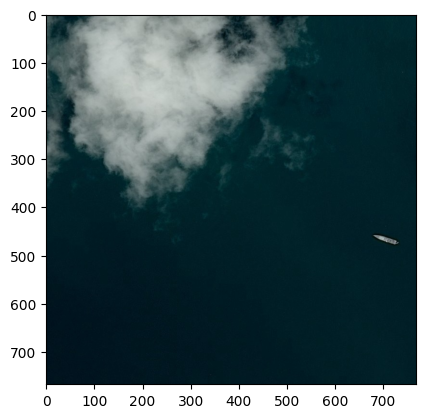

In [71]:
ds = imread(os.path.join(train_dir, im_names[0]))
_ = plt.imshow(ds)


In [72]:
ORIG_SIZE = 768


In [73]:

class ModelConfig(Config):

    NAME = 'Initial'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    BACKBONE = 'resnet50'

    NUM_CLASSES = 2

    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64)  #different window sizes in RPN achors
    TRAIN_ROIS_PER_IMAGE = 64
    MAX_GT_INSTANCES = 2
    DETECTION_MAX_INSTANCES = 15
    DETECTION_MIN_CONFIDENCE = 0.85
    DETECTION_NMS_THRESHOLD = 0.0
    RUN_EAGERLY = False

    STEPS_PER_EPOCH = 15 if debug else 5
    VALIDATION_STEPS = 10 if debug else 3

    LOSS_WEIGHTS = {
        "rpn_class_loss": 30.0,
        "rpn_bbox_loss": 0.8,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 1.2
    }

config = ModelConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        15
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 30.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.2}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [74]:

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [75]:
class LoadDataset(utils.Dataset):
    """Dataset class for training our dataset.
    """

    def __init__(self, im_names, image_annotations, orig_height, orig_width):
        super().__init__(self)

        self.add_class('ship', 1, 'Ship')

        for i, fp in enumerate(im_names):
            annotations = image_annotations.query('ImageId=="' + fp + '"')['EncodedPixels']
            self.add_image('ship', image_id=i, path=os.path.join(train_dir, fp),
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
#         print(image_id, annotations)
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                mask[:, :, i] = rle_decode(a)
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)